# Evaluating and Tuning a Binary Classification Model

## Goals

After this lesson, you should be able to:

- Discussion of OneHotEncoder vs get_dummies
- Build and explain confusion matrices from a model output
- Calculate various binary classification metrics
- Explain the AUC/ROC curve, why it matters, and how to use it
- Understand when and how to optimize a model for various metrics
- Optimize a classification model based on costs

## Heart Disease Data Set

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

[Dataset info](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

In [2]:
df = pd.read_csv('./data/heart.csv')

In [3]:
print(df.shape)
df.head(3)

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In our dataset we have 303 patients and 13 independent variables and 1 binary target variable.

When we are working with classification problems it is always good practice to check the class balance.

In [19]:
df['target'].value_counts(normalize = True)

1    0.544554
0    0.455446
Name: target, dtype: float64

We see that approximately %45 of the patients are in the class 0 which refers to 'no presence' of a heart disease. Consequently, %54 of the patients have a heart disease. 

## Model Selection - Model Evaluations

- Model Selection/Model Comparison: What is the best parameters for a given model. Between different models which one is better models the reality.

Ex: If we are working with an app that runs a machine learning algorithm model selection is choosing the process of choosing a final algorithm to deploy.


- Model Evaluation: After selecting a 'best' model with model selection how this model will perform in the 'real' case.

Ex: Model evaluation is where we want to predict how successful this algorithm will be.

[sklearn - Why do we need Train-Test-Validation?](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

In [4]:
## For model evaluation we split our data into two parts: Train - Test

X = df.drop('target', axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 77, 
                                                    stratify = y, # in classification problems 
                                                                  # when you split the data 
                                                                  # you want to keep the ratio in the classes.
                                                    test_size = .2 # This is usually the ratio but it might change 
                                                                   # according to the problem at hand.
                                                   )

In [24]:
## Let's check number of 1 and 0 in both datasets
y_train.mean(), y_test.mean()

(0.5454545454545454, 0.5409836065573771)

## Handling Categorical Variables

[A good blog post on handling categorical variables](https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Preprocessing-Missing-Data-Categorical-Data.php)

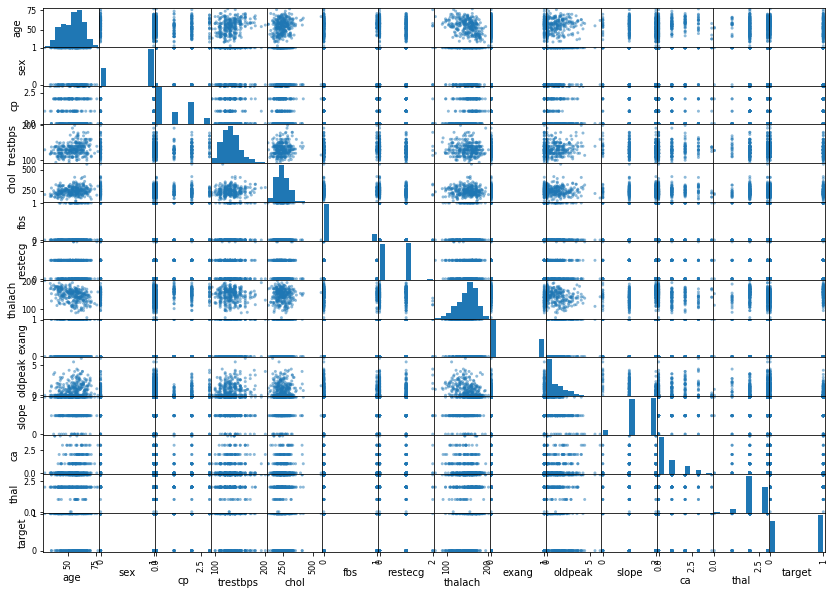

In [29]:
# we can also check the categorical variables with scatter matrix plot
# but notice that this is not practical in higher dimensions
pd.plotting.scatter_matrix(df, figsize= (14, 10))
plt.show()

__Your Turn__

- Write a function that finds the categorical variables.

In [6]:
# %load -r 1-7 supplement.py
col = [c for c in df.columns if c not in ['target']]
numclasses=[]
for c in col:
    numclasses.append(len(np.unique(df[[c]])))

threshold=10
categorical_variables = list(np.array(col)[np.array(numclasses)<threshold])

In [7]:
categorical_variables

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [9]:
remaining_list = [i for i in df.columns.tolist() if i not in categorical_variables]
remaining_list.remove('target')

## double check the categorical variables from data_information
remaining_list

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

__Your Turn__

- Convert Categorical Variables to OneHotEncoding

- [Dummies vs OneHot: Read the second answer](https://stackoverflow.com/questions/36631163/pandas-get-dummies-vs-sklearns-onehotencoder-what-are-the-pros-and-cons)

In [15]:
pd.get_dummies(X_train, columns= categorical_variables, drop_first= True).shape

(242, 22)

Now try to transform test data with get_dummies method.

In [16]:
## your code here.

In [2]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

In [3]:
df.head(3)

NameError: name 'df' is not defined

In [4]:
# %load -r 55-68 supplement.py
## create an encoder object. This will help us to convert
## categorical variables to new columns
encoder = OneHotEncoder(handle_unknown= 'error',
                        drop='first',
                        categories= 'auto')

## Create an columntransformer object.
## This will help us to merge transformed columns
## with the rest of the dataset.

ct = ColumnTransformer(transformers =[('ohe', encoder, ['sex'])],
                                    remainder= 'passthrough')
ct.fit(X_train)
X = ct.transform(X_train)

NameError: name 'X_train' is not defined

Now try to transform test dataset by using ct object.

In [37]:
# your code here.

Xtest = ct.transform(X_test)

__Don't forget!!__

- Apply the same transformations to the test data.

In [38]:
# %load -r 71-72 supplement.py
Xtest  = ct.transform(X_test)
Xtest.shape

(61, 22)

__Scaling Features__

[Different Scalers and Their Effect on Data](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
standard_scaler = StandardScaler()
standard_scaler.fit(X)
X = standard_scaler.transform(X)
## apply the trained transformations to test.

Xtest = standard_scaler.transform(Xtest)

In [41]:
Xtest.shape

(61, 22)

In [42]:
np.mean(X,axis = 0)

## What do you expect if you check the means of X_test? Try

array([-1.83507938e-17, -5.18409925e-17,  8.16610324e-17,  8.25785721e-17,
        2.24797224e-17,  0.00000000e+00,  6.99624013e-18,  3.79861432e-16,
       -2.84437304e-17,  7.06505561e-17,  7.20268656e-17, -1.22950318e-16,
        2.38560319e-17, -7.34031752e-18,  7.34031752e-17, -6.78979370e-17,
       -2.38560319e-17,  4.12892860e-17, -4.17251174e-16,  5.32173020e-17,
        6.00988497e-16, -4.49594448e-17])

[Check sklearn for documentation of Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


[For solvers](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [65]:
# %load -r 17-18 supplement.py
lr = LogisticRegression(C = 1e9, solver = 'saga', max_iter=10000, penalty='l2')
lr.fit(X, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)

In [66]:
lr.score(X, y_train)

0.8925619834710744

In [46]:
## What is this score?
print(lr.score(X, y_train))

0.8925619834710744


__Your Turn__

- Fit a logistic regression with C = 1 and $\ell_2$ regularization.

- Fit a logistic regression with C = 1 and $\ell_1$ regularization.

- Use 5-fold cross-validation with sklearn cross_validate

[sklearn - validation](https://scikit-learn.org/stable/modules/cross_validation.html)

[sklearn -  cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

[sklearn - cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [68]:
# %load -r 20-52 supplement.py
cv = StratifiedKFold(n_splits= 5, random_state=1019, shuffle=True)

lr_vanilla = LogisticRegression(C = 1e9,
                                solver = 'newton-cg',
                                max_iter=1000)

l2_reg = LogisticRegression(C = 1,
                            solver = 'newton-cg',
                            max_iter=1000)

l1_reg = LogisticRegression(C = 1,
                           solver= 'saga',
                           penalty = 'l1',
                            max_iter=1000)

cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X = X, y = y_train,
                            cv = cv,
                            n_jobs=-1,
                            return_estimator= True,
                            return_train_score=True)

cv_l2 = cross_validate(estimator=l2_reg, X = X, y = y_train,
                    cv = cv,
                    n_jobs=-1,
                    return_estimator= True,
                    return_train_score=True)

cv_l1 = cross_validate(estimator=l1_reg, X = X, y = y_train,
                    cv = cv,
                    n_jobs=-1,
                    return_estimator= True,
                    return_train_score=True)

In [69]:
## let's see train and validation scores
vanilla_result = np.concatenate((cv_vanilla['train_score'].reshape(-1,1), 
 
                                 cv_vanilla['test_score'].reshape(-1,1)), axis=1)

l2_result = np.concatenate((cv_l2['train_score'].reshape(-1,1), 
                cv_l2['test_score'].reshape(-1,1)), axis=1)

l1_result = np.concatenate((cv_l1['train_score'].reshape(-1,1), 
                cv_l1['test_score'].reshape(-1,1)), axis=1)

In [70]:
vanilla_result

array([[0.85492228, 0.85714286],
       [0.88082902, 0.81632653],
       [0.91237113, 0.8125    ],
       [0.91237113, 0.8125    ],
       [0.90206186, 0.8125    ]])

In [71]:
l2_result

array([[0.87046632, 0.89795918],
       [0.88601036, 0.81632653],
       [0.90206186, 0.8125    ],
       [0.91237113, 0.77083333],
       [0.90721649, 0.8125    ]])

In [72]:
l1_result

array([[0.88082902, 0.95918367],
       [0.88082902, 0.85714286],
       [0.90206186, 0.8125    ],
       [0.91752577, 0.77083333],
       [0.90206186, 0.8125    ]])

In [211]:
print(vanilla_result.mean(axis=0), l1_result.mean(axis=0), l2_result.mean(axis=0))

[0.89251108 0.82219388] [0.8966615  0.84243197] [0.89562523 0.82202381]


In [73]:
lr = cv_vanilla['estimator'][0]
lr.score(X,y_train)

0.8553719008264463

- We got an accuracy score of .82, but what does that tell us? Just that 82% of the time we are correct, nothing about how we are correct or how we are wrong

### The Default Measure (in most prebuilt models) - Accuracy

$$ \frac{(TP + TN)}{(TP + FP + TN + FN)} $$

<img src='./images/conf_matrix_classification_metrics.png' width=650/>

Category definitions - possible outcomes in binary classification

- TP = True Positive (class 1 correctly classified as class 1) - e.g. Patient with cancer tests positive for cancer
- TN = True Negative (class 0 correctly classified as class 0) - e.g. Patient without cancer tests negative for cancer
- FP = False Positive (class 0 incorrectly classified as class 1) - e.g. Patient without cancer tests positive for cancer
- FN = False Negative (class 1 incorrectly classified as class 0) - e.g. Patient with cancer tests negative for cancer

 $$ \text{Possible misclassifications} $$

<img src='./images/type-1-type-2.jpg' width=400/>
 

In [76]:
predictions = lr.predict(X)
actual = y_train

In [77]:
confusion_matrix(actual, predictions)

array([[ 91,  19],
       [ 16, 116]])

__My eyes!!!__

In [78]:
pd.DataFrame(confusion_matrix(actual, predictions), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,91,19
actual 1,16,116


In [80]:
rec = 116/(16+116)

pre = 116/(19+116)

In [81]:
print(rec, pre)

0.8787878787878788 0.8592592592592593


- We got more false positives than false negatives. What would we likely prefer in the case of this dataset?

## Other metrics

__Misclassification Rate__

 $$ 1 - \text{accuracy} $$ 

 $$ \text{OR} $$

 $$ \frac{FP + FN}{TP + FP + TN + FN} $$

__Sensitivity__ (AKA True Positive Rate, Recall, and Probability of Detection)

$$ \frac{TP}{TP + FN} $$

__Specificity__ (AKA True Negative Rate)

$$ \frac{TN}{TN + FP} $$

__Your Turn__

- Write functions that returns the Recall, Precision and $F_1$ score.

- Which of these metrics would we want to optimize for in a heart disease detection algorithm?

False Positives and False Negatives each have some cost associated with them.

__Write Your Own Cost Function__

In [93]:
def your_metric(confusion_matrix):
    TP = confusion_matrix[0,0]
    TN = confusion_matrix[1,1]
    FP = confusion_matrix[0,1]
    FN = confusion_matrix[1,0]
    return 0*TN + 5*FP 

your_metric(confusion_matrix(actual, predictions))

75

### Let's figure out how to optimize!

Remember that Logistic Regression gives probability predictions for each class, in addition to the final classification. By default, threshold for the prediction is set to 0.5, but we can adjust that threshold.

In [83]:
predictions

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])

In [82]:
lr.predict_proba(X)

array([[1.95763184e-01, 8.04236816e-01],
       [2.71978363e-01, 7.28021637e-01],
       [6.20810070e-02, 9.37918993e-01],
       [6.21613652e-01, 3.78386348e-01],
       [8.03644289e-01, 1.96355711e-01],
       [9.93095481e-01, 6.90451913e-03],
       [9.14601715e-04, 9.99085398e-01],
       [9.57028131e-01, 4.29718686e-02],
       [4.57038464e-02, 9.54296154e-01],
       [9.12875225e-01, 8.71247751e-02],
       [6.51860329e-02, 9.34813967e-01],
       [6.22611193e-02, 9.37738881e-01],
       [1.11131007e-01, 8.88868993e-01],
       [7.53405169e-01, 2.46594831e-01],
       [9.06482575e-01, 9.35174245e-02],
       [7.77467490e-02, 9.22253251e-01],
       [8.27298153e-01, 1.72701847e-01],
       [2.38737893e-01, 7.61262107e-01],
       [2.48772216e-02, 9.75122778e-01],
       [9.88534371e-01, 1.14656285e-02],
       [7.55895529e-01, 2.44104471e-01],
       [1.41820945e-02, 9.85817905e-01],
       [7.18116175e-01, 2.81883825e-01],
       [9.94108434e-01, 5.89156556e-03],
       [8.755624

In [96]:
lr.predict(X)

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])

In [104]:
## set threshold to a number
threshold =0.9
predicts = []
for item in lr.predict_proba(X):
    if item[1] <= threshold:
        predicts.append(0)
    else:
        predicts.append(1)

conf_matrix = pd.DataFrame(confusion_matrix(y_train, predicts),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

fpr = FPR(confusion_matrix(y_train, predicts))

tpr = TPR(confusion_matrix(y_train, predicts))

print(tpr, fpr)

0.5303030303030303 0.03636363636363636


0.34545454545454546

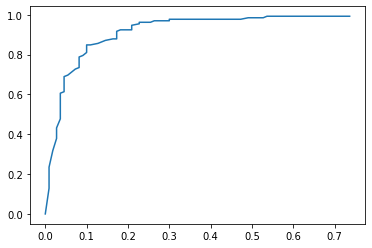

In [87]:
def FPR(confusion_matrix):
    TN = confusion_matrix[0,0]
    TP = confusion_matrix[1,1]
    FP = confusion_matrix[0,1]
    FN = confusion_matrix[1,0]
    return FP/(FP + TN)

def TPR(confusion_matrix):
    TN = confusion_matrix[0,0]
    TP = confusion_matrix[1,1]
    FP = confusion_matrix[0,1]
    FN = confusion_matrix[1,0]
    return TP/(TP + FN)
fprs = []
tprs = []
for threshold in np.linspace(0,1,100):
    predicts = []
    for item in lr.predict_proba(X):
        if item[1] <= threshold:
            predicts.append(0)
        else:
            predicts.append(1)
    c = confusion_matrix(y_train, predicts)
    fprs.append(FPR(c))
    tprs.append(TPR(c))
    
plt.plot(fprs[1:], tprs[1:])

### The AUC / ROC curve (Area Under Curve of the Receiver Operating Characteristic)

<img src='images/pop-curve.png' width=500/>


In [105]:
results_df = X_train.copy()

In [106]:
results_df['probabilities'] = lr.predict_proba(X)[:, 0]
results_df['target'] = y_train

In [107]:
results_df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,probabilities,target
121,59,1,0,138,271,0,0,182,0,0.0,2,0,2,0.195763,1
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2,0.271978,1


In [108]:
import seaborn as sns

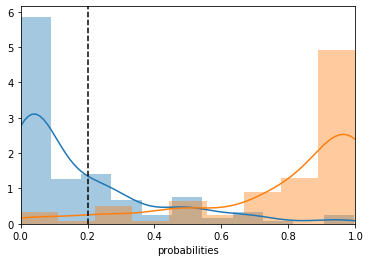

In [109]:
sns.distplot(results_df[results_df.target == 1].probabilities)
sns.distplot(results_df[results_df.target == 0].probabilities)
plt.axvline(x = 0.2, linestyle = '--', c = 'black')
plt.xlim([0,1])
plt.show()

In [110]:
import matplotlib.pyplot as plt

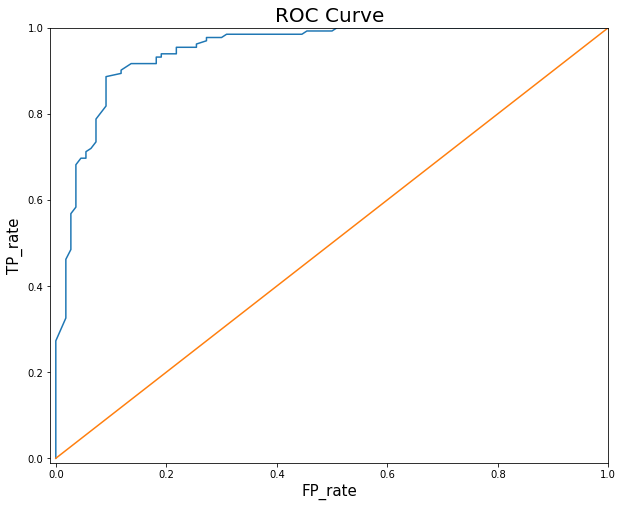

In [117]:
x_list = []
y_list = []

for x in np.linspace(0, 1, 100):
    
    # Same predictions based on predict_proba thresholds
    predicts = []
    
    for item in lr.predict_proba(X):
        if item[0] <= x:
            predicts.append(1)
        else:
            predicts.append(0)

    conf_matrix = pd.DataFrame(confusion_matrix(y_train, predicts), index = ['actual 0', 'actual 1'], 
                     columns = ['predicted 0', 'predicted 1'])
    
    
    # Assign TP, TN, FP, FN
    true_positives = conf_matrix['predicted 1'][1]
    true_negatives = conf_matrix['predicted 0'][0]
    false_positives = conf_matrix['predicted 1'][0]
    false_negatives = conf_matrix['predicted 0'][1]

    
    # Calculate Sensitivity and Specificity
    sensitivity = true_positives / (true_positives + false_negatives)

    specificity = true_negatives / (true_negatives + false_positives)
    
    
    # Append to lists to graph
    x_list.append(1 - specificity)

    y_list.append(sensitivity)

    
# Plot ROC curve

plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('FP_rate', fontsize = 15)
plt.ylabel('TP_rate', fontsize = 15)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 1)
plt.plot(x_list, y_list);
plt.plot([0, 1], [0, 1]);

# x = 1 - specificity
# y = sensitivity

In [116]:
lr = cv_l1['estimator'][0]

In [113]:
from sklearn.metrics import auc

In [118]:
auc(x_list, y_list)

0.9480716253443527

In [114]:
auc(x_list, y_list)

0.9328512396694215

# Play Ground

### Let's add associated costs to our False Negatives and False Positives to our loop and minimize the cost
This is the naive way to optimize, but works well - you could also create a closed form optimization function

In [76]:
def my_eyes_cost_much(num_thres = 100, p_fp = 3, p_tn = 0.5, p_tp = 1, p_fn = 2):

    _thres = []; tpr = [] ; fpr = [] ; cost = []

    prediction = lr.predict_proba(X)

    ## Different code for same objective to calculate metrics at thresholds
    
    for thres in np.linspace(0.01, 1, num_thres):
        
        _thres.append(thres)
        predicts = np.zeros((prediction.shape[0], 1)) 
        predicts[np.where(prediction[:, 1] >= thres)] = 1

        conf_matrix = confusion_matrix(y_train, predicts)

        tp = conf_matrix[1, 1]
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1]
        fn = conf_matrix[1, 0]

        sensitivity = tp / (tp + fn)
        tnr = specificity = tn / (tn + fp)
        fnr = 1 - sensitivity

        tpr.append(sensitivity)
    
        fpr.append(1 - specificity)
        
        # add a cost function (this involves domain knowledge)
        
        current_cost = (p_fp * fp) + (p_tn * tn) + (p_tp * tp) + (p_fn * fn)
            
        cost.append(current_cost)  

    return fpr, tpr, cost, _thres

In [77]:
fpr, tpr, cost, thres = my_eyes_cost_much(num_thres = 100, p_fp = 3, p_tn = 0.5, p_tp = 1, p_fn = 2)

In [78]:
cost_idx = np.argmin(cost)
min_cost_threshold = fpr[cost_idx], tpr[cost_idx], thres[cost_idx]

print(min_cost_threshold)

(0.09090909090909094, 0.8560606060606061, 0.5800000000000001)


Text(0.15090909090909094, 0.826060606060606, 'Threshold:0.58')

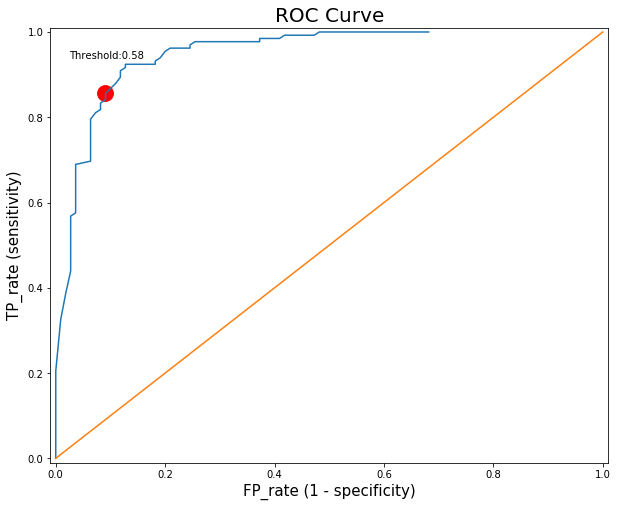

In [79]:
ax = plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('FP_rate (1 - specificity)', fontsize = 15)
plt.ylabel('TP_rate (sensitivity)', fontsize = 15)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1]);
plt.scatter(min_cost_threshold[0], min_cost_threshold[1], marker ='o', color = 'red', s=250)
ax.text(min_cost_threshold[0] + 0.06, min_cost_threshold[1] - 0.03, 'Threshold:'+ str(round(min_cost_threshold[2], 2)))


## Extra Resources

- [Visualization of harmonic means for F1-scores](https://medium.com/swlh/visualizing-the-geometric-and-harmonic-means-e8b9c5a818ae)